In [1]:
from matplotlib import colors as m_colors
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler
from yaml import load as load_yaml, FullLoader

from dataset import KIDataset, train_test_split_stratified
from models.rocket import ROCKET
from processor.processor import Leif
from utils.const import SEED
from utils.data import binarize
from utils.metric import patient_soft_accuracy
from utils.misc import set_random_state
from utils.path import config_path

set_random_state(SEED)
!conda activate eyetrackpdc

# Data parameters
BINARY_CLF = True

# Rocket parameters
NUM_KERNELS = 1000
NORMALIZE = True

# Classifier parameters
REG_FACTOR = 1e5


## Load configs

In [2]:
with open(f'{config_path}/leif.yaml', 'r') as reader:
    config = load_yaml(reader, Loader=FullLoader)

## Initialize Datasets and Dataloaders

In [3]:
# Configure processor
processor = Leif(config)

# Initialize Datasets
train_val_ds = KIDataset(data_processor=processor, train=True)
train_ds, val_ds = train_test_split_stratified(train_val_ds, test_size=0.2)
test_ds = KIDataset(data_processor=processor, train=False, sources=('HC', 'PD_OFF', 'PD_ON'))

test_ds.s = test_ds.y.clone()
val_ds.s = val_ds.y.clone()

# Binarize dataset after split to make sure split is stratified w.r.t all three classes
if BINARY_CLF:
    for ds in [train_ds, val_ds, test_ds]:
        binarize(ds)

# Initialize Dataloaders
train_dl = DataLoader(train_ds,
                      batch_size=train_ds.x.shape[0],
                      sampler=ImbalancedDatasetSampler(train_ds, callback_get_label=lambda item: item.y))
val_dl = DataLoader(val_ds, batch_size=val_ds.x.shape[0])
test_dl = DataLoader(test_ds, batch_size=test_ds.x.shape[0])

loaded dataset from C:\Users\hejpa\Documents\GitHub\eye-track-pdc\data\ki\tmp\ki-HC,PD_OFF,PD_ON-seg-train.pth
loaded dataset from C:\Users\hejpa\Documents\GitHub\eye-track-pdc\data\ki\tmp\ki-HC,PD_OFF,PD_ON-seg-test.pth


## Initialize Rocket and classifier

In [4]:
# Initialize Rocket
rocket = ROCKET(c_in=train_ds.x.shape[1],
                seq_len=train_ds.x.shape[2],
                n_kernels=NUM_KERNELS,
                normalize=NORMALIZE)

# Initialize Classifiers
ridge_clf = RidgeClassifier(alpha=REG_FACTOR, random_state=SEED)
forest_clf = RandomForestClassifier(
    random_state=SEED,
    n_jobs=1,
    n_estimators=200,
    max_samples=0.5,
    max_depth=2
)

## Prepare batches

In [5]:
# For evaluation metrics
labels = ['HC', 'PD']
# Batch is entire dataset
train_batch = next(iter(train_dl))
test_batch = next(iter(test_dl))

## Fit Model

In [6]:
# Perform ROCKET transformation stage
features = rocket(train_batch.x)

# Fit Classifier
ridge_clf.fit(features, train_batch.y)
forest_clf.fit(features, train_batch.y)

RandomForestClassifier(max_depth=2, max_samples=0.5, n_estimators=200, n_jobs=1,
                       random_state=42)

## Evaluate ridge classifier on segment classification

mean F1 score: 0.5767516009619282
Segment classification on test set:
              precision    recall  f1-score   support

          HC       0.40      0.56      0.46       297
          PD       0.77      0.63      0.69       682

    accuracy                           0.61       979
   macro avg       0.58      0.59      0.58       979
weighted avg       0.65      0.61      0.62       979



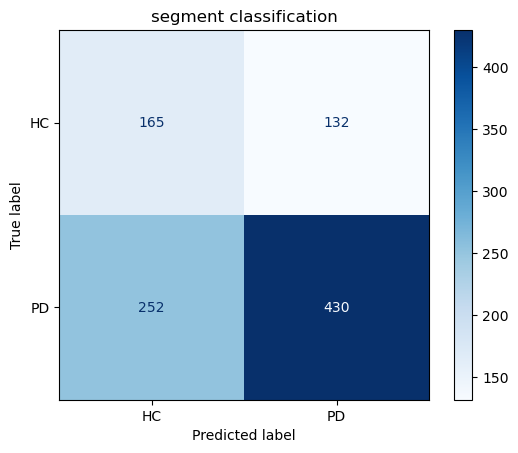

In [7]:
# Perform ROCKET transformation stage
test_features = rocket(test_batch.x)

# Make predictions on test set
pred = ridge_clf.predict(test_features)

# The RidgeClassifier maps the targets to {-1, 1}, but our labels are {0, 1}
pred[pred < 0] = 0

# Compute metrics
report = classification_report(test_batch.y.numpy(), pred, target_names=labels)

# Construct the confusion matrix
cf_matrix = confusion_matrix(test_batch.y, pred)

# Plot metrics and display confusion matrix
print(f"mean F1 score: {f1_score(test_batch.y.numpy(), pred, average='macro')}")
print(f'Segment classification on test set:\n{report}')
figure = ConfusionMatrixDisplay(cf_matrix, display_labels=labels).plot(cmap='Blues')
figure.ax_.set_title('segment classification')
plt.show()

## Evaluate random forest on segment classification

mean F1 score: 0.589902240151976
Segment classification on test set:
              precision    recall  f1-score   support

          HC       0.46      0.35      0.40       297
          PD       0.74      0.82      0.78       682

    accuracy                           0.68       979
   macro avg       0.60      0.59      0.59       979
weighted avg       0.66      0.68      0.67       979



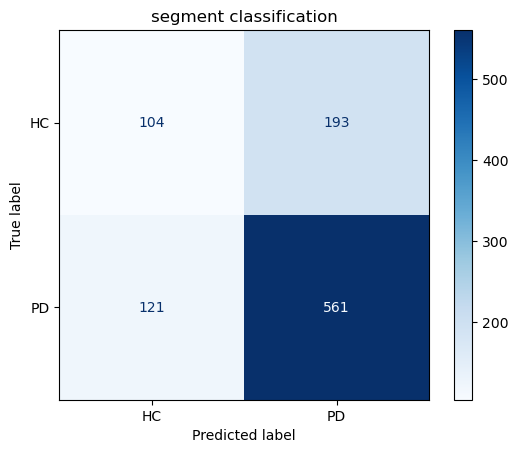

In [8]:
pred = forest_clf.predict(test_features.detach())

# The RidgeClassifier maps the targets to {-1, 1}, but our labels are {0, 1}
pred[pred < 0] = 0

# Compute metrics
report = classification_report(test_batch.y.numpy(), pred, target_names=labels)

# Construct the confusion matrix
cf_matrix = confusion_matrix(test_batch.y, pred)

# Plot metrics and display confusion matrix
print(f"mean F1 score: {f1_score(test_batch.y.numpy(), pred, average='macro')}")
print(f'Segment classification on test set:\n{report}')
figure = ConfusionMatrixDisplay(cf_matrix, display_labels=labels).plot(cmap='Blues')
figure.ax_.set_title('segment classification')
plt.show()

## Visualize latent ROCKET space

In [ ]:
pca = PCA(n_components=50)
tsne = TSNE(n_components=2, perplexity=50)

proj = pca.fit_transform(test_features, test_batch.y)
manifold = tsne.fit_transform(proj)

C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


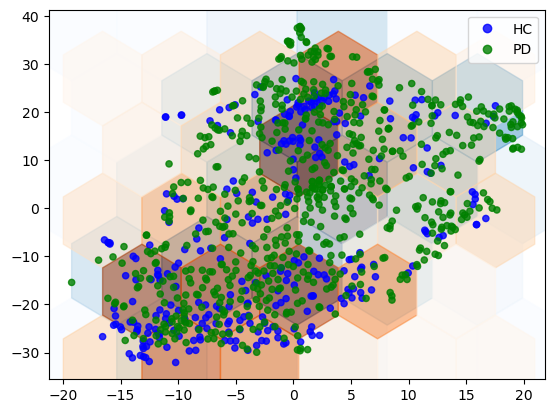

In [12]:
colors = ['blue', 'darkorange', 'green']
cmap = m_colors.ListedColormap(colors)

fig, ax = plt.subplots()
scatter = ax.scatter(manifold[:, 0], manifold[:, 1], c=test_batch.y, s=20, alpha=0.8, cmap=cmap)
ax.legend(handles=scatter.legend_elements()[0], labels=labels)
plt.show()

## Patient Wise aggregation

In [10]:
p_pred, p_label, p_acc = patient_soft_accuracy(segment_scores=pred, y=test_batch.y, z=test_batch.z, threshold=0.6)
print(p_acc)

0.75


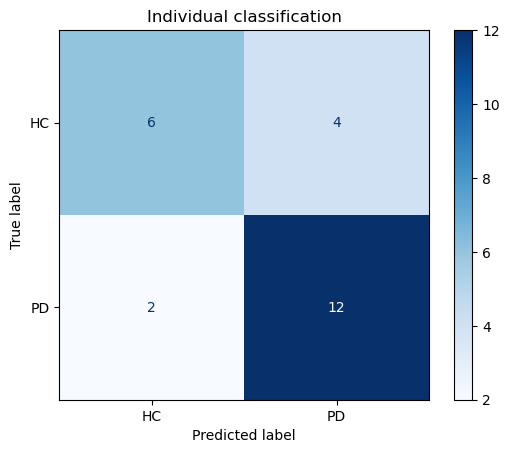

In [11]:
# Construct the confusion matrix
cf_matrix = confusion_matrix(p_label, p_pred)

# Display confusion matrix
figure = ConfusionMatrixDisplay(cf_matrix, display_labels=labels).plot(cmap='Blues')
figure.ax_.set_title('Individual classification')
plt.show()

## Evaluate ridge classifier on segment classification

mean F1 score: 0.5767516009619282
Segment classification on test set:
              precision    recall  f1-score   support

          HC       0.40      0.56      0.46       297
          PD       0.77      0.63      0.69       682

    accuracy                           0.61       979
   macro avg       0.58      0.59      0.58       979
weighted avg       0.65      0.61      0.62       979



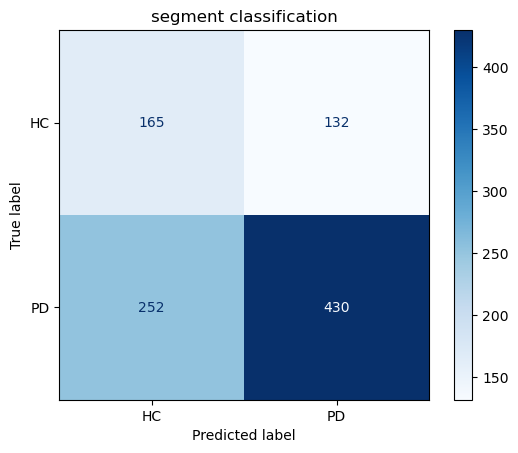

In [6]:
# Perform ROCKET transformation stage
test_features = rocket(test_batch.x)

# Make predictions on test set
pred = ridge_clf.predict(test_features)

# The RidgeClassifier maps the targets to {-1, 1}, but our labels are {0, 1}
pred[pred < 0] = 0

# Compute metrics
report = classification_report(test_batch.y.numpy(), pred, target_names=labels)

# Construct the confusion matrix
cf_matrix = confusion_matrix(test_batch.y, pred)

# Plot metrics and display confusion matrix
print(f"mean F1 score: {f1_score(test_batch.y.numpy(), pred, average='macro')}")
print(f'Segment classification on test set:\n{report}')
figure = ConfusionMatrixDisplay(cf_matrix, display_labels=labels).plot(cmap='Blues')
figure.ax_.set_title('segment classification')
plt.show()

## Evaluate random forest on segment classification

mean F1 score: 0.589902240151976
Segment classification on test set:
              precision    recall  f1-score   support

          HC       0.46      0.35      0.40       297
          PD       0.74      0.82      0.78       682

    accuracy                           0.68       979
   macro avg       0.60      0.59      0.59       979
weighted avg       0.66      0.68      0.67       979



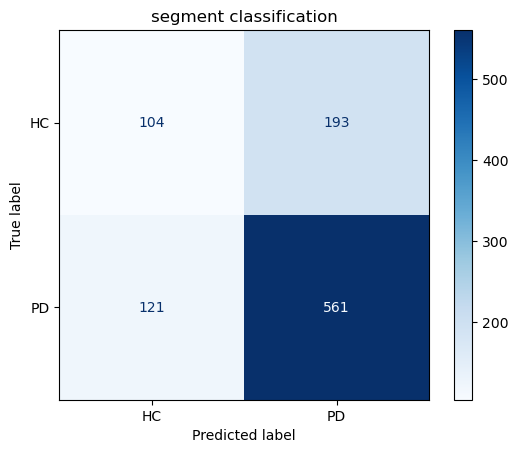

In [7]:
pred = forest_clf.predict(test_features.detach())

# The RidgeClassifier maps the targets to {-1, 1}, but our labels are {0, 1}
pred[pred < 0] = 0

# Compute metrics
report = classification_report(test_batch.y.numpy(), pred, target_names=labels)

# Construct the confusion matrix
cf_matrix = confusion_matrix(test_batch.y, pred)

# Plot metrics and display confusion matrix
print(f"mean F1 score: {f1_score(test_batch.y.numpy(), pred, average='macro')}")
print(f'Segment classification on test set:\n{report}')
figure = ConfusionMatrixDisplay(cf_matrix, display_labels=labels).plot(cmap='Blues')
figure.ax_.set_title('segment classification')
plt.show()

C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


tensor(1.)


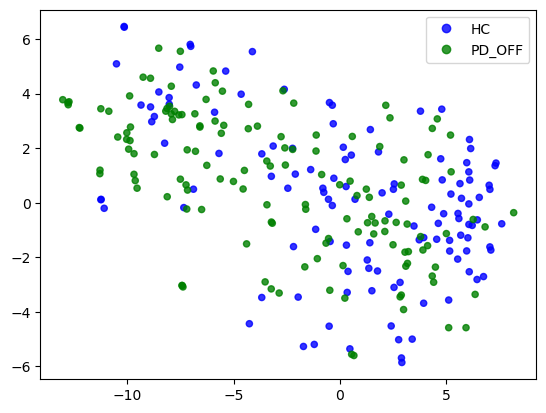

In [14]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
from torch import unique

pca = PCA(n_components=50)
proj = pca.fit_transform(test_features, test_batch.y)
tsne = TSNE(n_components=2, perplexity=50)
manifold = tsne.fit_transform(proj)

colors = ['blue', 'darkorange', 'green']
cmap = mcolors.ListedColormap(colors)
labels = ['HC', 'PD_OFF', 'PD_ON']
l = (labels[int(y)] for y in test_batch.y)
fig, ax = plt.subplots()
pd = manifold[test_batch.y == 0]
hc = manifold[test_batch.y == 1]
#hb = ax.hexbin(hc[:, 0], hc[:, 1], gridsize=5, cmap='Blues', alpha=0.5)
#hb = ax.hexbin(pd[:, 0], pd[:, 1], gridsize=5, cmap='Oranges', alpha=0.5)
unique, idx = unique(test_batch.s)
print(idx)
scatter = ax.scatter(manifold[:, 0], manifold[:, 1], c=test_batch.y, s=20, alpha=0.8, cmap=cmap)

ax.legend(handles=scatter.legend_elements()[0], labels=labels)
plt.show()

In [9]:
import numpy as np
from torch import sigmoid
import torch


# Only works for binary classification. Pass either logits or scores ~[0, 1].
def patient_soft_accuracy(*, segment_logits=None, segment_scores=None, y, z, threshold=0.2):
    unique, inv_idx = np.unique(z, return_inverse=True)
    patient_pred = np.zeros(unique.shape)
    patient_label = np.zeros(unique.shape)
    for i, p in enumerate(unique):
        patient_mask = z == unique[i]
        if segment_logits is not None:
            patient_segment_scores = sigmoid(torch.from_numpy(segment_logits[patient_mask])).numpy()
        elif segment_scores is not None:
            patient_segment_scores = segment_scores[patient_mask]
        else:
            raise ValueError("mandatory to pass segment scores or logits")
        mean_pred = np.mean(patient_segment_scores, axis=-1)
        patient_pred[i] = 1 if mean_pred > threshold else 0
        patient_label[i] = y[patient_mask][0]
    patient_acc = (patient_pred == patient_label).mean().item()
    return patient_pred, patient_label, patient_acc

In [20]:
p_pred, p_label, p_acc = patient_soft_accuracy(segment_scores=pred, y=test_batch.y, z=test_batch.z, threshold=0.6)
print(p_acc)

0.75


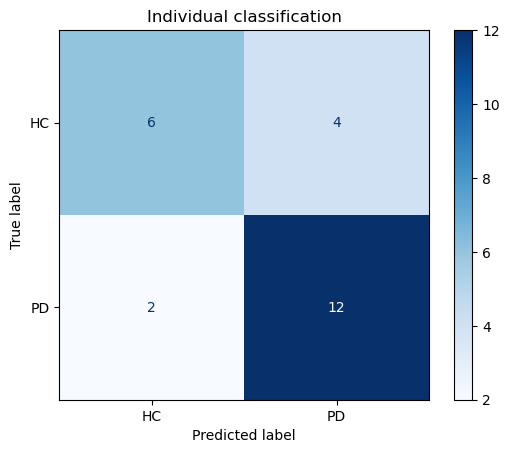

In [21]:
# Construct the confusion matrix
cf_matrix = confusion_matrix(p_label, p_pred)

# Display confusion matrix
figure = ConfusionMatrixDisplay(cf_matrix, display_labels=labels).plot(cmap='Blues')
figure.ax_.set_title('Individual classification')
plt.show()